# 📊 Análisis Exploratorio de Datos (EDA) – Técnico

## Introducción
- **Objetivo**: explorar diferencias entre URLs phishing y legítimas, identificando patrones y proponiendo *features candidatas*.  
- **Contexto del dataset**: 200 URLs balanceadas (100 legítimas, 100 phishing), organizadas en varias categorías sectoriales.  
- **Aviso**: este notebook **no es feature engineering**, sino exploración previa para guiar esa fase.  


In [49]:
import re
import math
import random
import statistics
import numpy as np
import pandas as pd
from urllib.parse import urlparse
import tldextract
from collections import Counter
from pathlib import Path
# Configuración de Pandas para que no corte las URLs
pd.set_option("display.max_colwidth", 160)

# Semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("✅ Librerías cargadas correctamente.")


✅ Librerías cargadas correctamente.


In [53]:
DATASET_PATH = Path("../../data/dataset/dataset_prototipo.csv")

# Cargar dataset
df = pd.read_csv(DATASET_PATH)

# Estandarizar nombres de columnas por seguridad
df.columns = [c.strip().lower() for c in df.columns]

print("📐 Shape del dataset:", df.shape)
print("🗂️ Columnas:", list(df.columns))

# Mostrar primeras filas
df.head(5)

📐 Shape del dataset: (200, 6)
🗂️ Columnas: ['url', 'label', 'categoria', 'matched_target', 'notas', 'campaign']


,url,label,categoria,matched_target,notas,campaign
0,https://www.caixabank.es/particular/banca-digital.html,0,banca,caixabank,home bancaria oficial,NaN
1,https://accounts.google.com/ServiceLogin?service=wise,0,saas,google,login Google oficial,NaN
2,https://www.roblox.com/es/upgrades/robux?ctx=navpopover,0,gaming,roblox,portal Roblox oficial,NaN
3,https://zoom.us/es/join,0,saas,zoom,página de reuniones Zoom oficial,NaN
4,https://www.roblox.com/es/login,0,gaming,roblox,login Roblox oficial,NaN


In [55]:


# === Carga de CSV y esquema ===
print("🔍 Columnas detectadas:", list(df.columns))
expected_cols = {"url", "label", "categoria", "matched_target", "notas", "campaign"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"❌ Faltan columnas obligatorias: {missing}")
else:
    print("✅ Esquema correcto: contiene todas las columnas requeridas.")

# === Duplicados ===
dup_mask = df.duplicated(subset=["url"], keep=False)
dup_count = dup_mask.sum()
print(f"\n🔁 Duplicados exactos por URL: {dup_count}")
if dup_count > 0:
    display(df[dup_mask].sort_values("url").head(5))

# === Nulos ===
print("\n🕳️ Nulos por columna:")
print(df.isnull().sum())

# === Validación de etiquetas ===
label_vals = df["label"].unique()
print(f"\n🏷️ Valores únicos en 'label': {label_vals}")
bad_labels = set(label_vals) - {0, 1}
if bad_labels:
    raise ValueError(f"❌ Etiquetas inválidas encontradas: {bad_labels}")
else:
    print("✅ Etiquetas válidas (0 = legítima, 1 = phishing).")


🔍 Columnas detectadas: ['url', 'label', 'categoria', 'matched_target', 'notas', 'campaign']
✅ Esquema correcto: contiene todas las columnas requeridas.

🔁 Duplicados exactos por URL: 0

🕳️ Nulos por columna:
url                 0
label               0
categoria           0
matched_target      0
notas               0
campaign          100
dtype: int64

🏷️ Valores únicos en 'label': [0 1]
✅ Etiquetas válidas (0 = legítima, 1 = phishing).


In [56]:
# === Balance de clases ===
class_counts = df["label"].value_counts().sort_index()
class_counts.index = class_counts.index.map({0: "legítima", 1: "phishing"})

print("📊 Balance de clases:")
display(class_counts)

# Convertimos a % para el MD
total = class_counts.sum()
for clase, count in class_counts.items():
    print(f"  - {clase}: {count} URLs ({(count/total)*100:.1f}%)")

# === Distribución por categoría y label ===
cat_dist = df.groupby(["categoria", "label"]).size().unstack(fill_value=0)
cat_dist["total"] = cat_dist.sum(axis=1)
cat_dist = cat_dist.sort_values("total", ascending=False)

print("\n📊 Distribución por categoría y clase:")
display(cat_dist)

📊 Balance de clases:


label
legítima    100
phishing    100
Name: count, dtype: int64

  - legítima: 100 URLs (50.0%)
  - phishing: 100 URLs (50.0%)

📊 Distribución por categoría y clase:


label,0,1,total
categoria,,,
banca,43,37,80
genérico,0,18,18
saas,9,9,18
público,7,7,14
telecomunicaciones,7,7,14
logística,6,7,13
cripto,5,5,10
streaming,4,5,9
e-commerce,8,0,8


In [57]:
# Extracción de partes de la URL

def parse_url_parts(u: str):
    try:
        p = urlparse(u)
        return p.scheme.lower(), p.netloc.lower(), p.path, p.query, p.fragment
    except:
        return None, None, None, None, None

# Aplicar a todo el dataset
parsed = df["url"].apply(parse_url_parts)
df[["scheme", "netloc", "path", "query", "fragment"]] = pd.DataFrame(parsed.tolist(), index=df.index)

# Extraer dominio raíz usando tldextract
def get_root_domain(netloc):
    try:
        ext = tldextract.extract(netloc)
        return ext.registered_domain
    except:
        return None

df["root_domain"] = df["netloc"].apply(get_root_domain)

# Verificamos las nuevas columnas
print("🧩 Nuevas columnas añadidas:", ["scheme", "netloc", "path", "query", "fragment", "root_domain"])
df[["url", "scheme", "netloc", "path", "query", "root_domain"]].head(5)


🧩 Nuevas columnas añadidas: ['scheme', 'netloc', 'path', 'query', 'fragment', 'root_domain']


,url,scheme,netloc,path,query,root_domain
0,https://www.caixabank.es/particular/banca-digital.html,https,www.caixabank.es,/particular/banca-digital.html,,caixabank.es
1,https://accounts.google.com/ServiceLogin?service=wise,https,accounts.google.com,/ServiceLogin,service=wise,google.com
2,https://www.roblox.com/es/upgrades/robux?ctx=navpopover,https,www.roblox.com,/es/upgrades/robux,ctx=navpopover,roblox.com
3,https://zoom.us/es/join,https,zoom.us,/es/join,,zoom.us
4,https://www.roblox.com/es/login,https,www.roblox.com,/es/login,,roblox.com


In [58]:
#  Métricas básicas de longitud

df["url_len"] = df["url"].apply(lambda x: len(str(x)))
df["netloc_len"] = df["netloc"].apply(lambda x: len(str(x)))
df["path_len"] = df["path"].apply(lambda x: len(str(x)))
df["query_len"] = df["query"].apply(lambda x: len(str(x)))

# Vista rápida por tipo de URL
df[["label", "url_len", "netloc_len", "path_len", "query_len"]].groupby("label").describe().round(2)


url_len                                               netloc_len         \
        count   mean    std   min   25%   50%    75%    max      count   mean   
label                                                                           
0       100.0  44.33  17.57  19.0  32.0  39.0  53.25  111.0      100.0  16.69   
1       100.0  43.54  20.25  21.0  31.0  39.0  47.00  130.0      100.0  22.59   

       ... path_len       query_len                                        
       ...      75%   max     count  mean   std  min  25%  50%  75%   max  
label  ...                                                                 
0      ...    25.25  91.0     100.0  0.49  2.92  0.0  0.0  0.0  0.0  23.0  
1      ...    18.00  77.0     100.0  1.89  9.20  0.0  0.0  0.0  0.0  61.0  

[2 rows x 32 columns]

In [59]:
# Inconsistencias entre matched_target y root_domain

def clean_string(s):
    return str(s).lower().replace(" ", "").replace("-", "").replace("_", "")

def target_in_domain(row):
    target = clean_string(row.get("matched_target", ""))
    root = clean_string(row.get("root_domain", ""))
    if not target or not root:
        return False
    return target in root

df["target_in_root_domain"] = df.apply(target_in_domain, axis=1)

# 🔍 1. Casos sospechosos: phishing con root domain que contiene la marca
inconsist_phish = df[(df["label"] == 1) & (df["target_in_root_domain"] == True)]

# 🔍 2. Casos sospechosos: legítimas sin la marca en el dominio
inconsist_legit = df[(df["label"] == 0) & (df["target_in_root_domain"] == False) & (df["matched_target"].notna())]

print(f"⚠️ Phishing con dominio que contiene la marca: {len(inconsist_phish)}")
print(f"⚠️ Legítimas con matched_target pero sin la marca en el dominio: {len(inconsist_legit)}")

# Mostramos algunos ejemplos
print("\n🔎 Ejemplos de phishing con dominio que contiene la marca:")
display(inconsist_phish[["url", "matched_target", "root_domain"]].head(5))

print("\n🔎 Ejemplos de legítimas sin la marca en root_domain:")
display(inconsist_legit[["url", "matched_target", "root_domain"]].head(5))


⚠️ Phishing con dominio que contiene la marca: 19
⚠️ Legítimas con matched_target pero sin la marca en el dominio: 6

🔎 Ejemplos de phishing con dominio que contiene la marca:


,url,matched_target,root_domain
112,https://coinbasewalletsupport.es,coinbase,coinbasewalletsupport.es
116,https://correos-paqueteria.com/asset.php,correos,correos-paqueteria.com
117,https://dgtt48.lat/yyjxzpjg/e2Walj/7,dgt,dgtt48.lat
119,https://ingbanksecure.com/,ing,ingbanksecure.com
121,https://www.app-ingmovil-cliente.com,ing,app-ingmovil-cliente.com



🔎 Ejemplos de legítimas sin la marca en root_domain:


,url,matched_target,root_domain
5,https://www.unicismadrid.es,unimadrid,unicismadrid.es
25,https://pasarela.clave.gob.es/Proxy2/ServiceProvider,cl@ve,clave.gob.es
36,https://www.seg-social.es/wps/portal/wss/internet/Inicio,seguridadsocial,seg-social.es
43,https://www.ruralcentral.es/es/particulares/004-seguridad-ruralvia,cajarural,ruralcentral.es
52,https://www.bmedonline.es,mediolanum,bmedonline.es


In [61]:
#Señales estructurales (longitudes + composición netloc)

# Funciones auxiliares
def count_digits(s):
    return sum(c.isdigit() for c in str(s)) if pd.notnull(s) else 0

def count_specials(s):
    return sum(1 for c in str(s) if not c.isalnum()) if pd.notnull(s) else 0

# Nuevas columnas
df["digits_in_netloc"] = df["netloc"].apply(count_digits)
df["specials_in_netloc"] = df["netloc"].apply(count_specials)

# Agregamos todas las métricas relevantes por clase
columns_to_group = [
    "url_len", "netloc_len", "path_len", "query_len",
    "digits_in_netloc", "specials_in_netloc"
]

stats = df[["label"] + columns_to_group].groupby("label").agg(["mean", "median", "std", "min", "max"]).round(2)
stats

url_len                        netloc_len                       ...  \
         mean median    std min  max       mean median   std min max  ...   
label                                                                 ...   
0       44.33   39.0  17.57  19  111      16.69   16.0  4.83   7  30  ...   
1       43.54   39.0  20.25  21  130      22.59   23.0  8.31   6  53  ...   

      digits_in_netloc                      specials_in_netloc               \
                  mean median   std min max               mean median   std   
label                                                                         
0                 0.01    0.0  0.10   0   1               2.02    2.0  0.35   
1                 0.29    0.0  0.94   0   6               2.30    2.0  1.09   

               
      min max  
label          
0       1   3  
1       1   7  

[2 rows x 30 columns]

In [62]:
# ✅ Celda 10 – Tokens en dominios (host)

# Separador por símbolos comunes y estructuras
def split_tokens(netloc):
    if pd.isnull(netloc): return []
    return re.split(r"[.\-_]", netloc.lower())

df["host_tokens"] = df["netloc"].apply(split_tokens)

# Función para contar tokens más frecuentes
def top_tokens(token_series, top_n=20):
    counter = Counter()
    for tokens in token_series.dropna():
        counter.update(tokens)
    return pd.DataFrame(counter.most_common(top_n), columns=["token", "count"])

# Tokens por clase
top_legit = top_tokens(df[df["label"] == 0]["host_tokens"])
top_phish = top_tokens(df[df["label"] == 1]["host_tokens"])

print("✅ Top tokens en dominios legítimos:")
display(top_legit)

print("✅ Top tokens en dominios phishing:")
display(top_phish)


✅ Top tokens en dominios legítimos:


,token,count
0,www,69
1,es,63
2,com,34
3,ing,5
4,bbva,5
5,gob,4
6,unicajabanco,4
7,bancosantander,4
8,caixabank,3
9,ibercaja,3


✅ Top tokens en dominios phishing:


,token,count
0,com,53
1,es,25
2,webcindario,11
3,www,10
4,app,9
5,ing,7
6,me,5
7,net,4
8,cuenta,4
9,web,4


In [64]:
# Análisis de TLDs y acortadores

# TLD usando tldextract (extraemos el 'suffix')
df["tld"] = df["netloc"].apply(lambda netloc: tldextract.extract(netloc).suffix)

# Distribución de TLD por clase
tld_dist = df.groupby(["tld", "label"]).size().unstack(fill_value=0)
tld_dist["total"] = tld_dist.sum(axis=1)
tld_dist = tld_dist.sort_values("total", ascending=False)

print("📊 Distribución de TLDs por clase:")
display(tld_dist.head(15))

# Detectar acortadores conocidos
SHORTENERS = {
    "bit.ly", "t.co", "tinyurl.com", "is.gd", "buff.ly", "cutt.ly", "ow.ly", "goo.gl", 
    "shorturl.at", "lnkd.in", "rebrand.ly", "adf.ly", "rb.gy", "s.id", "v.gd", "shrtco.de"
}

df["is_shortener"] = df["root_domain"].isin(SHORTENERS)

# Conteo de shorteners por clase
short_counts = df.groupby(["is_shortener", "label"]).size().unstack(fill_value=0)

print("\n🔗 Uso de acortadores por clase:")
display(short_counts)


📊 Distribución de TLDs por clase:


label,0,1,total
tld,,,
com,34,44,78
es,59,15,74
app,0,5,5
net,1,4,5
me,0,5,5
com.es,0,5,5
gob.es,4,0,4
digital,0,4,4
info,0,3,3



🔗 Uso de acortadores por clase:


label,0,1
is_shortener,,
False,100,99
True,0,1


In [65]:
#Keywords relevantes en path y query

# Lista de palabras clave frecuentes en campañas (en minúscula)
KW_ES = [
    "cliente", "cuenta", "verifica", "seguridad", "confirmar", "acceso",
    "clave", "sms", "token", "envio", "pago", "factura",
    "dgt", "correos", "gob", "sede", "tramites", "aeat", "certificado"
]

# Función para detectar si alguna keyword aparece
def contains_kw(text):
    if pd.isnull(text): return False
    text = text.lower()
    return any(kw in text for kw in KW_ES)

# Aplicamos flags
df["kw_in_path"] = df["path"].apply(contains_kw)
df["kw_in_query"] = df["query"].apply(contains_kw)

# Distribución por clase
kw_stats = df.groupby("label")[["kw_in_path", "kw_in_query"]].sum()
kw_stats["total"] = df["label"].value_counts()
kw_stats["pct_path"] = (kw_stats["kw_in_path"] / kw_stats["total"] * 100).round(1)
kw_stats["pct_query"] = (kw_stats["kw_in_query"] / kw_stats["total"] * 100).round(1)

print("📊 Presencia de keywords en path y query por clase:")
display(kw_stats)

📊 Presencia de keywords en path y query por clase:


,kw_in_path,kw_in_query,total,pct_path,pct_query
label,,,,,
0,22,0,100,22.0,0.0
1,8,0,100,8.0,0.0


In [66]:
# Medidas avanzadas (entropía, path_depth, num_params)

import math

# Entropía de dominio (caracteres)
def entropy(s):
    if pd.isnull(s): return 0
    p, lns = {}, float(len(s))
    for c in s:
        p[c] = p.get(c, 0) + 1
    return -sum(count / lns * math.log2(count / lns) for count in p.values())

df["domain_entropy"] = df["root_domain"].apply(entropy)

# Profundidad del path (nº de '/')
df["path_depth"] = df["path"].apply(lambda x: str(x).count("/"))

# Nº de parámetros en la query
df["num_params"] = df["query"].apply(lambda x: str(x).count("="))

# Agrupamos por clase
adv_stats = df.groupby("label")[["domain_entropy", "path_depth", "num_params"]].agg(["mean", "median", "std", "min", "max"]).round(2)

print("📊 Medidas avanzadas por clase:")
display(adv_stats)

📊 Medidas avanzadas por clase:


domain_entropy                          path_depth                       \
                mean median   std   min   max       mean median   std min max   
label                                                                           
0               3.04   3.10  0.32  2.50  3.61       2.17    2.0  1.47   0   7   
1               3.28   3.38  0.42  2.25  4.11       1.31    1.0  1.06   0   5   

      num_params                       
            mean median   std min max  
label                                  
0           0.03    0.0  0.17   0   1  
1           0.07    0.0  0.26   0   1

## 10. Síntesis final

- **Señales fuertes encontradas:**
  - `domain_entropy` mayor en phishing → indica aleatoriedad y typosquatting.
  - `path_depth` mayor en legítimas → rutas jerárquicas reales frente a URLs simples de phishing.
  - `netloc_len` más largo en phishing → dominios complejos o generados.
  - `digits_in_netloc` casi ausente en legítimas, frecuente en phishing → buena señal binaria.
  - Algunos TLDs (`.me`, `.top`, `.app`) y hostings gratuitos (`webcindario`, `blogspot`, `godaddysites`) muy asociados a phishing.

- **Sesgos detectados:**
  - Tokens de marca (`bbva`, `caixabank`, `ing`) presentes tanto en phishing como en legítimas → riesgo de sobreajuste si se usan directamente como features.
  - Legit no tiene URLs en categoría "genérico", y phishing no tiene en e-commerce/seguros/viajes → sesgo de categoría parcial.
  - Keywords como `cliente`, `seguridad`, `acceso` aparecen más en legítimas que en phishing → invertir hipótesis previa.

- **Acciones sobre datos:**
  - No se eliminaron duplicados ni relabels: dataset ya estaba depurado.
  - 19 phishing contienen la marca en el dominio raíz → revisar manualmente si se amplía el dataset.
  - Se descartó el uso de acortadores y keywords en query por baja presencia.
  - Marcar categorías subrepresentadas para ampliación futura: phishing en e-commerce/seguros/viajes y legítimas genéricas.

- **Lista de *features candidatas* para feature engineering:**

  🔹 Estructurales (numéricas o bucketizadas):
  - `url_len`  
  - `netloc_len`  
  - `path_len`  
  - `query_len`  
  - `path_depth`  
  - `domain_entropy`  

  🔹 Composición:
  - `digits_in_netloc`  
  - `specials_in_netloc`  

  🔹 Semánticas:
  - `host_tokens` (a tratar con cuidado, nunca crudos)  
  - `kw_in_path`  
  - `kw_in_query` (descartada en este dataset, pero válida en otros)

  🔹 Técnicas / Infraestructura:
  - `scheme` (`http` vs `https`)
  - `tld` (confiables vs sospechosos)
  - `is_shortener` (poco útil aquí, útil en otros feeds)
  - `target_in_root_domain` (útil para análisis, no para entrenamiento directo)


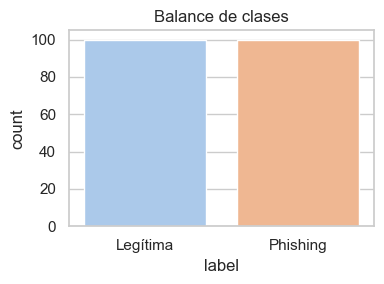

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
sns.countplot(data=df, x="label", palette="pastel")
plt.xticks([0, 1], ["Legítima", "Phishing"])
plt.title("Balance de clases")
plt.tight_layout()
plt.savefig("balance_clases.png")  # ← se guarda aquí mismo
plt.show()


<Figure size 600x400 with 0 Axes>

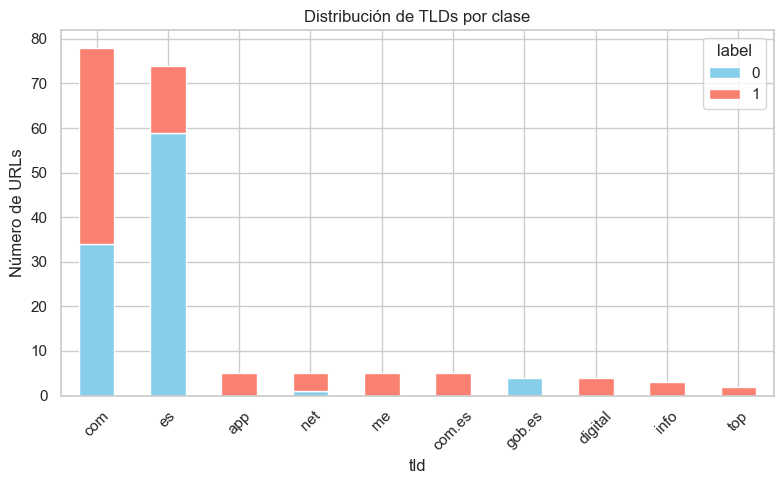

In [69]:
# Agrupar y contar
tld_counts = df.groupby(["tld", "label"]).size().unstack(fill_value=0)

# Seleccionar los TLDs más frecuentes (top 10 por total)
top_tlds = tld_counts.sum(axis=1).sort_values(ascending=False).head(10).index

# Graficar
plt.figure(figsize=(6,4))
tld_counts.loc[top_tlds].plot(kind="bar", stacked=True, color=["skyblue", "salmon"])
plt.title("Distribución de TLDs por clase")
plt.ylabel("Número de URLs")
plt.xticks(rotation=45)
plt.tight_layout()

# Guardar en el mismo notebook
plt.savefig("tlds_por_clase.png")
plt.show()


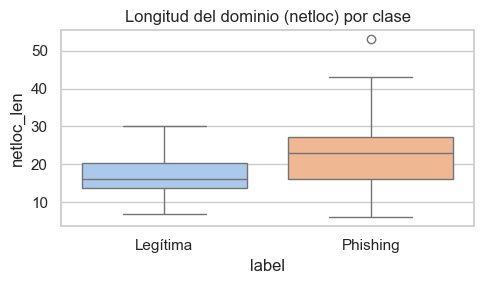

In [70]:
plt.figure(figsize=(5,3))
sns.boxplot(data=df, x="label", y="netloc_len", palette="pastel")
plt.xticks([0, 1], ["Legítima", "Phishing"])
plt.title("Longitud del dominio (netloc) por clase")
plt.tight_layout()

# Guardar
plt.savefig("netloc_len_boxplot.png")
plt.show()


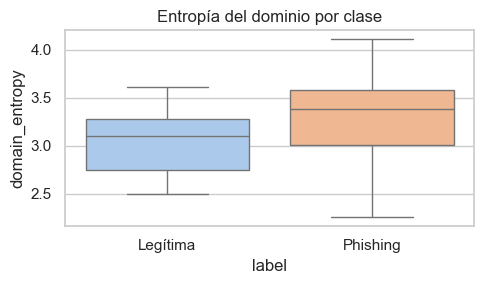

In [71]:
plt.figure(figsize=(5,3))
sns.boxplot(data=df, x="label", y="domain_entropy", palette="pastel")
plt.xticks([0, 1], ["Legítima", "Phishing"])
plt.title("Entropía del dominio por clase")
plt.tight_layout()

# Guardar
plt.savefig("domain_entropy_boxplot.png")
plt.show()
